In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

In [2]:
# Load the Fashion-MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# The Fashion-MNIST classes
class_names = [
    "T-shirt/top", 
    "Trouser", 
    "Pullover", 
    "Dress", 
    "Coat", 
    "Sandal", 
    "Shirt", 
    "Sneaker", 
    "Bag", 
    "Ankle boot"
]


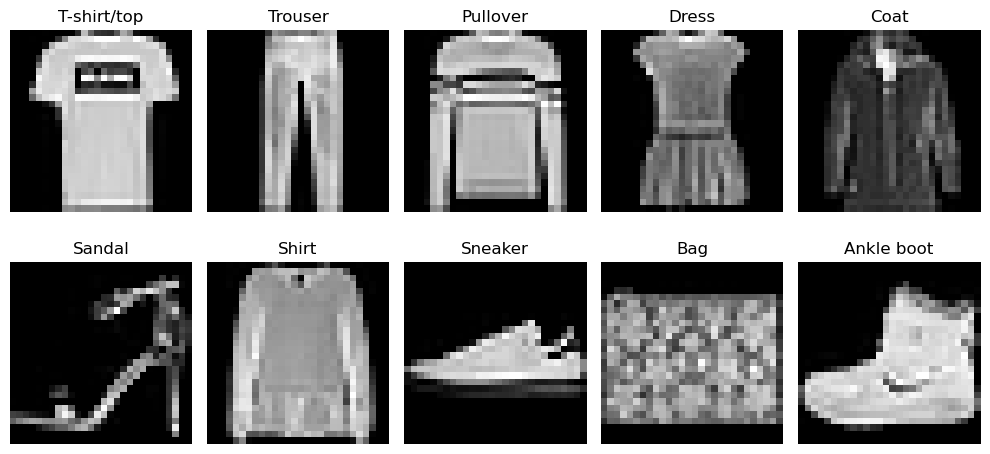

In [5]:
# Prepare a figure with 2 rows and 5 columns (for 10 total classes)
plt.figure(figsize=(10, 5))

# Find and plot one sample per class
for label in range(10):
    # Get the first index in X_train that corresponds to the current label
    idx = np.where(y_train == label)[0][0]
    
    plt.subplot(2, 5, label + 1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title(class_names[label])
    plt.axis('off')  # Hide axis ticks

plt.tight_layout()
plt.show()

In [13]:
# 1. utils.py
import numpy as np
from keras.datasets import fashion_mnist

def load_fashion_mnist():
    """
    Loads the Fashion-MNIST dataset using keras.datasets.fashion_mnist,
    returns training and test sets.
    """
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    
    # X_train: (60000, 28, 28)
    # y_train: (60000,)
    # X_test:  (10000, 28, 28)
    # y_test:  (10000,)
    
    # Flatten images from 28x28 to 784
    X_train = X_train.reshape(-1, 784).astype(np.float32)  # -> (60000, 784)
    X_test  = X_test.reshape(-1, 784).astype(np.float32)   # -> (10000, 784)
    
    # Normalize to [0, 1]
    X_train /= 255.0
    X_test  /= 255.0
    
    return X_train, y_train, X_test, y_test

def one_hot_encode(labels, num_classes=10):
    """
    Converts integer labels into one-hot vectors.
    labels:      1D array of shape (N,)
    num_classes: number of categories (default 10 for Fashion-MNIST)
    Returns:     2D array of shape (N, num_classes)
    """
    one_hot = np.zeros((labels.shape[0], num_classes)) # (N, num_classes) -> (60000, 10)
    one_hot[np.arange(labels.shape[0]), labels] = 1.0
    return one_hot

def get_minibatches(X, y, batch_size, shuffle=True):
    """
    Generates mini-batches of data.
      - X: input features (N, d)
      - y: labels (N, num_classes) or (N,)
      - batch_size: size of each batch
      - shuffle: whether to shuffle data before batching
    Yields tuples (X_batch, y_batch) each with shape:
      X_batch: (batch_size, d)
      y_batch: (batch_size, num_classes) or (batch_size,)
    """
    N = X.shape[0]
    indices = np.arange(N)
    if shuffle:
        np.random.shuffle(indices)
    
    for start_idx in range(0, N, batch_size):
        end_idx = start_idx + batch_size
        batch_indices = indices[start_idx:end_idx]
        yield X[batch_indices], y[batch_indices]

In [17]:
# 2. model.py
import numpy as np

class NeuralNetwork:
    """
    A flexible feedforward neural network built using only NumPy for matrix ops.
    
    Example usage:
        nn = NeuralNetwork(layer_sizes=[784, 128, 64, 10], activation='relu')
        # Then call nn.forward(...) and nn.backward(...) or use train_batch(...)
    """
    
    def __init__(self, layer_sizes, activation='relu', seed=42):
        """
        layer_sizes:  list of layer dimensions, e.g. [784, 128, 64, 10]
                      - layer_sizes[i] = number of units in layer i
        activation:   name of hidden activation function, e.g. 'relu' or 'sigmoid'
        seed:         random seed for reproducibility
        """
        np.random.seed(seed)
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes) - 1  # number of parameter sets: (input->hidden1), ..., (hiddenK->output)
        self.activation_name = activation
        
        # Initialize parameters: for each consecutive pair of layers
        # create a weight matrix W and bias vector b
        self.params = {}
        for i in range(self.num_layers):
            in_dim = layer_sizes[i]     # # of units in layer i
            out_dim = layer_sizes[i+1]  # # of units in layer i+1
            
            # Xavier-like initialization range
            limit = np.sqrt(6.0 / (in_dim + out_dim))
            self.params[f'W{i}'] = np.random.uniform(-limit, limit, (in_dim, out_dim))
            # W{i}: shape (layer_sizes[i], layer_sizes[i+1])
            
            self.params[f'b{i}'] = np.zeros(out_dim)
            # b{i}: shape (layer_sizes[i+1],)

    def activation(self, z, derivative=False):
        """
        Applies the chosen activation function (ReLU or Sigmoid) on z.
        z: (batch_size, layer_sizes[i+1]) in hidden layers
        derivative=True => returns d(ReLU)/dz or d(Sigmoid)/dz
        """
        if self.activation_name == 'relu':
            if derivative:
                # derivative of ReLU is 1 for z>0, else 0
                return (z > 0).astype(float)
            return np.maximum(0, z)
        elif self.activation_name == 'sigmoid':
            if derivative:
                sig = 1.0 / (1.0 + np.exp(-z))
                return sig * (1.0 - sig)
            return 1.0 / (1.0 + np.exp(-z))
        else:
            raise ValueError("Unsupported activation function. Use 'relu' or 'sigmoid'.")

    def softmax(self, logits):
        """
        Softmax function for the output layer.
        logits: (batch_size, num_classes)
        Returns: (batch_size, num_classes) with each row summing to 1
        """
        # subtract max logits for numeric stability
        shifted = logits - np.max(logits, axis=1, keepdims=True)
        exps = np.exp(logits)
        return exps / np.sum(exps, axis=1, keepdims=True)

    def forward(self, X):
        """
        Forward pass.
        X: (batch_size, layer_sizes[0]) i.e. (batch_size, 784) for MNIST
        
        Returns: 
         - caches: dict of intermediate Z and A for each layer
           e.g. caches['A0'] = X (input)
                caches['Z1'], caches['A1']
                ...
                caches['Z{num_layers}'], caches['A{num_layers}']
        """
        caches = {}
        H = X  # (batch_size, layer_sizes[0])
        caches['A0'] = H
        
        for i in range(self.num_layers):
            W = self.params[f'W{i}']   # shape: (layer_sizes[i], layer_sizes[i+1])
            b = self.params[f'b{i}']   # shape: (layer_sizes[i+1],)
            
            # Z shape: (batch_size, layer_sizes[i+1])
            A = H @ W + b  # (batch_size, layer_sizes[0]) * (layer_sizes[i], layer_sizes[i+1]) + (layer_sizes[i+1],)
            
            if i < self.num_layers - 1:
                # hidden layer => ReLU or Sigmoid
                H = self.activation(A, derivative=False)
            else:
                # last layer => softmax
                H = self.softmax(A)
            
            caches[f'A{i+1}'] = A  # pre-activation (linear output)
            caches[f'H{i+1}'] = H  # activation output
        
        return caches

    # def compute_loss(self, A_last, Y):
    #     """
    #     Cross-entropy loss for softmax outputs.
    #     A_last: (batch_size, num_classes) predicted probabilities
    #     Y:      (batch_size, num_classes) true one-hot labels
    #     """
    #     eps = 1e-9
    #     # log_probs: (batch_size, num_classes)
    #     log_probs = np.log(A_last + eps)  
    #     # sum(Y * log_probs) across classes => (batch_size,) then average
    #     loss = -np.mean(np.sum(Y * log_probs, axis=1))
    #     return loss
    # 
    # def backward(self, caches, X, Y):
    #     """
    #     Backpropagation: returns dict of gradients for all parameters.
    #     
    #     caches: forward pass outputs (Z and A for each layer)
    #     X:      input batch, shape (batch_size, layer_sizes[0])
    #     Y:      ground truth one-hot, shape (batch_size, num_classes)
    #     
    #     Returns:
    #      - grads: dict with dW{i} and db{i} for each layer i
    #     """
    #     grads = {}
    #     batch_size = X.shape[0]
    #     
    #     # final layer's activation: (batch_size, layer_sizes[-1])
    #     A_last = caches[f'A{self.num_layers}']
    #     
    #     # derivative of cross-entropy loss w.r.t. final layer logits => (A_last - Y)
    #     # shape: (batch_size, layer_sizes[-1])
    #     dZ = A_last - Y
    #     
    #     # loop backward through layers
    #     for i in reversed(range(self.num_layers)):
    #         A_prev = caches[f'A{i}']  # shape: (batch_size, layer_sizes[i])
    #         W = self.params[f'W{i}']  # shape: (layer_sizes[i], layer_sizes[i+1])
    #         
    #         # dW: (layer_sizes[i], layer_sizes[i+1])
    #         dW = (A_prev.T @ dZ) / batch_size
    #         # db: (layer_sizes[i+1],)
    #         db = np.sum(dZ, axis=0) / batch_size
    #         
    #         grads[f'dW{i}'] = dW
    #         grads[f'db{i}'] = db
    #         
    #         if i > 0:
    #             # backprop to the previous layer
    #             Z_prev = caches[f'Z{i}']  # shape: (batch_size, layer_sizes[i])
    #             # dA_prev: (batch_size, layer_sizes[i])
    #             dA_prev = dZ @ W.T
    #             # dZ for the previous layer
    #             dZ = dA_prev * self.activation(Z_prev, derivative=True)
    #             
    #     return grads
    # 
    # def update_params(self, grads, lr=0.01):
    #     """
    #     Updates all parameters with a gradient descent step.
    #     grads: dictionary of gradients
    #     lr:    learning rate
    #     """
    #     for i in range(self.num_layers):
    #         self.params[f'W{i}'] -= lr * grads[f'dW{i}']
    #         self.params[f'b{i}'] -= lr * grads[f'db{i}']
    # 
    # def train_batch(self, X_batch, Y_batch, lr=0.01):
    #     """
    #     A single training step on one batch:
    #       1. forward pass
    #       2. compute loss
    #       3. backward pass
    #       4. update params
    # 
    #     X_batch: (batch_size, layer_sizes[0])
    #     Y_batch: (batch_size, num_classes)
    #     
    #     Returns: loss for this batch
    #     """
    #     # 1) Forward pass
    #     caches = self.forward(X_batch)
    #     
    #     # 2) Compute loss
    #     A_last = caches[f'A{self.num_layers}']  # (batch_size, layer_sizes[-1])
    #     loss = self.compute_loss(A_last, Y_batch)
    #     
    #     # 3) Backprop
    #     grads = self.backward(caches, X_batch, Y_batch)
    #     
    #     # 4) Parameter update
    #     self.update_params(grads, lr=lr)
    #     
    #     return loss


In [18]:
for x, y in get_minibatches(np.random.rand(7, 3), np.random.rand(7, 2), 3, shuffle=True):
    print("----")
    print('X:',x)
    print('y:',y)

----
X: [[0.41895189 0.27364565 0.67350287]
 [0.1377946  0.02143188 0.84015613]
 [0.08920954 0.71096086 0.51979849]]
y: [[0.55595242 0.39220416]
 [0.00400768 0.69456529]
 [0.1596289  0.45415125]]
----
X: [[0.81005878 0.11709951 0.27400528]
 [0.67847662 0.0542281  0.83634178]
 [0.28471719 0.54749968 0.1491305 ]]
y: [[0.24064614 0.90855689]
 [0.84952749 0.81780778]
 [0.042225   0.18678717]]
----
X: [[0.56688012 0.09970172 0.55586822]]
y: [[0.61774889 0.71548839]]


In [19]:
# 3. main.py
def main():
    # 1) Load the Fashion-MNIST data
    #    X_train: (60000, 784), y_train: (60000,)
    #    X_test:  (10000, 784), y_test:  (10000,)
    X_train, y_train, X_test, y_test = load_fashion_mnist()
    
    # 2) Define a feedforward network architecture
    #    Here we have 2 hidden layers: 128 and 64 neurons,
    #    and an output layer of size 10 (one for each class).
    layer_sizes = [784, 128, 64, 10] 
    nn = NeuralNetwork(layer_sizes=layer_sizes, activation='relu', seed=42)
    
    # 3) Run a forward pass on a small batch of images
    #    For demonstration, let's pick the first 5 training examples
    #    and see the network's output distribution (unnormalized at first).
    X_batch = X_train[:5]  # shape: (5, 784)
    
    # 4) Forward pass -> output is a probability distribution over 10 classes
    caches = nn.forward(X_batch)
    # The final output is in caches['A{num_layers}']
    probs = caches[f'H{nn.num_layers}']  # shape: (5, 10)
    
    # 5) Print the resulting probabilities
    print("Shape of output probabilities:", probs.shape)  # Should be (5, 10)
    print("Output probabilities for the first 5 images:")
    print(probs)  # Each row sums to 1 across 10 classes
    

if __name__ == "__main__":
    main()

Shape of output probabilities: (5, 10)
Output probabilities for the first 5 images:
[[0.18859663 0.04294926 0.06488609 0.04560309 0.11611695 0.05231554
  0.08524678 0.19793018 0.13305794 0.07329753]
 [0.11795866 0.0584322  0.05617246 0.04533545 0.15847986 0.03016604
  0.1177013  0.16624412 0.16572153 0.08378838]
 [0.12127995 0.06671921 0.08002385 0.07222481 0.10930827 0.06369443
  0.10842776 0.12256181 0.1422073  0.1135526 ]
 [0.10990005 0.05841984 0.06998805 0.05939602 0.11299519 0.04532769
  0.12472047 0.1275958  0.17919004 0.11246685]
 [0.14857518 0.04434551 0.06078144 0.04931808 0.12000402 0.0431512
  0.09246125 0.17815333 0.15746527 0.10574471]]
